In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-19 12:32:51.710493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.094991,0.086944,0.199151,0.929326,0.010891,0.090511,0.010666,0.020907,0.264449,1.000000,...,0.955616,0.849532,0.241862,0.100542,0.001952,0.433017,0.148646,0.002767,0.621245,0.340925
1,0.718595,0.891492,0.979353,0.883257,0.406406,0.454668,0.336789,0.424902,0.347061,0.758245,...,0.566681,0.925048,0.474398,0.393359,0.061594,0.079709,0.838948,0.033079,0.896105,0.379185
2,0.328205,0.207870,0.979444,0.414971,0.054905,0.038188,0.625212,0.640939,0.028793,0.043139,...,0.310750,0.767096,0.410916,0.036441,0.813381,0.043596,0.858440,0.037557,0.247857,0.036056


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.358563,0.889037,0.956548,0.225670,0.032771,0.028074,0.134850,0.907241,0.028143,0.142124,...,0.673154,0.644727,0.678105,0.038979,0.081767,0.258632,0.407270,0.087389,0.743665,0.859452
1,1.000000,0.318987,0.999082,1.000000,0.999997,0.731645,0.996072,0.985970,0.999998,0.066652,...,0.715289,0.979737,0.488520,0.012557,0.170775,0.083500,0.610125,0.332838,0.955608,0.005067
2,0.292931,0.802980,0.999981,0.909353,1.000000,0.082395,0.113834,0.356964,0.895042,0.943140,...,0.879742,0.645630,0.849530,0.045784,0.008849,0.063486,0.095798,0.220030,0.150195,0.143480


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=10,
    batch_size=16,
    encoder_batch_norm=True,
    epochs=905, 
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-19 12:32:57.571050: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/905
49/49 [==============================] - 2s 15ms/step - loss: 319.3820 - recon: 314.5052 - kl: 4.8768 - val_loss: 194.0954 - val_recon: 161.9455 - val_kl: 32.1500
Epoch 2/905
49/49 [==============================] - 0s 3ms/step - loss: 228.2752 - recon: 223.3441 - kl: 4.9311 - val_loss: 204.8109 - val_recon: 190.3311 - val_kl: 14.4798
Epoch 3/905
49/49 [==============================] - 0s 4ms/step - loss: 175.7718 - recon: 170.4444 - kl: 5.3274 - val_loss: 164.9477 - val_recon: 151.2286 - val_kl: 13.7191
Epoch 4/905
49/49 [==============================] - 0s 3ms/step - loss: 141.6615 - recon: 135.9773 - kl: 5.6842 - val_loss: 146.8254 - val_recon: 131.5500 - val_kl: 15.2754
Epoch 5/905
49/49 [==============================] - 0s 6ms/step - loss: 124.6740 - recon: 118.7456 - kl: 5.9284 - val_loss: 118.8530 - val_recon: 108.3476 - val_kl: 10.5053
Epoch 6/905
49/49 [==============================] - 0s 4ms/step - loss: 116.8676 - recon: 110.6857 - kl: 6.1820 - val_loss: 112.

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

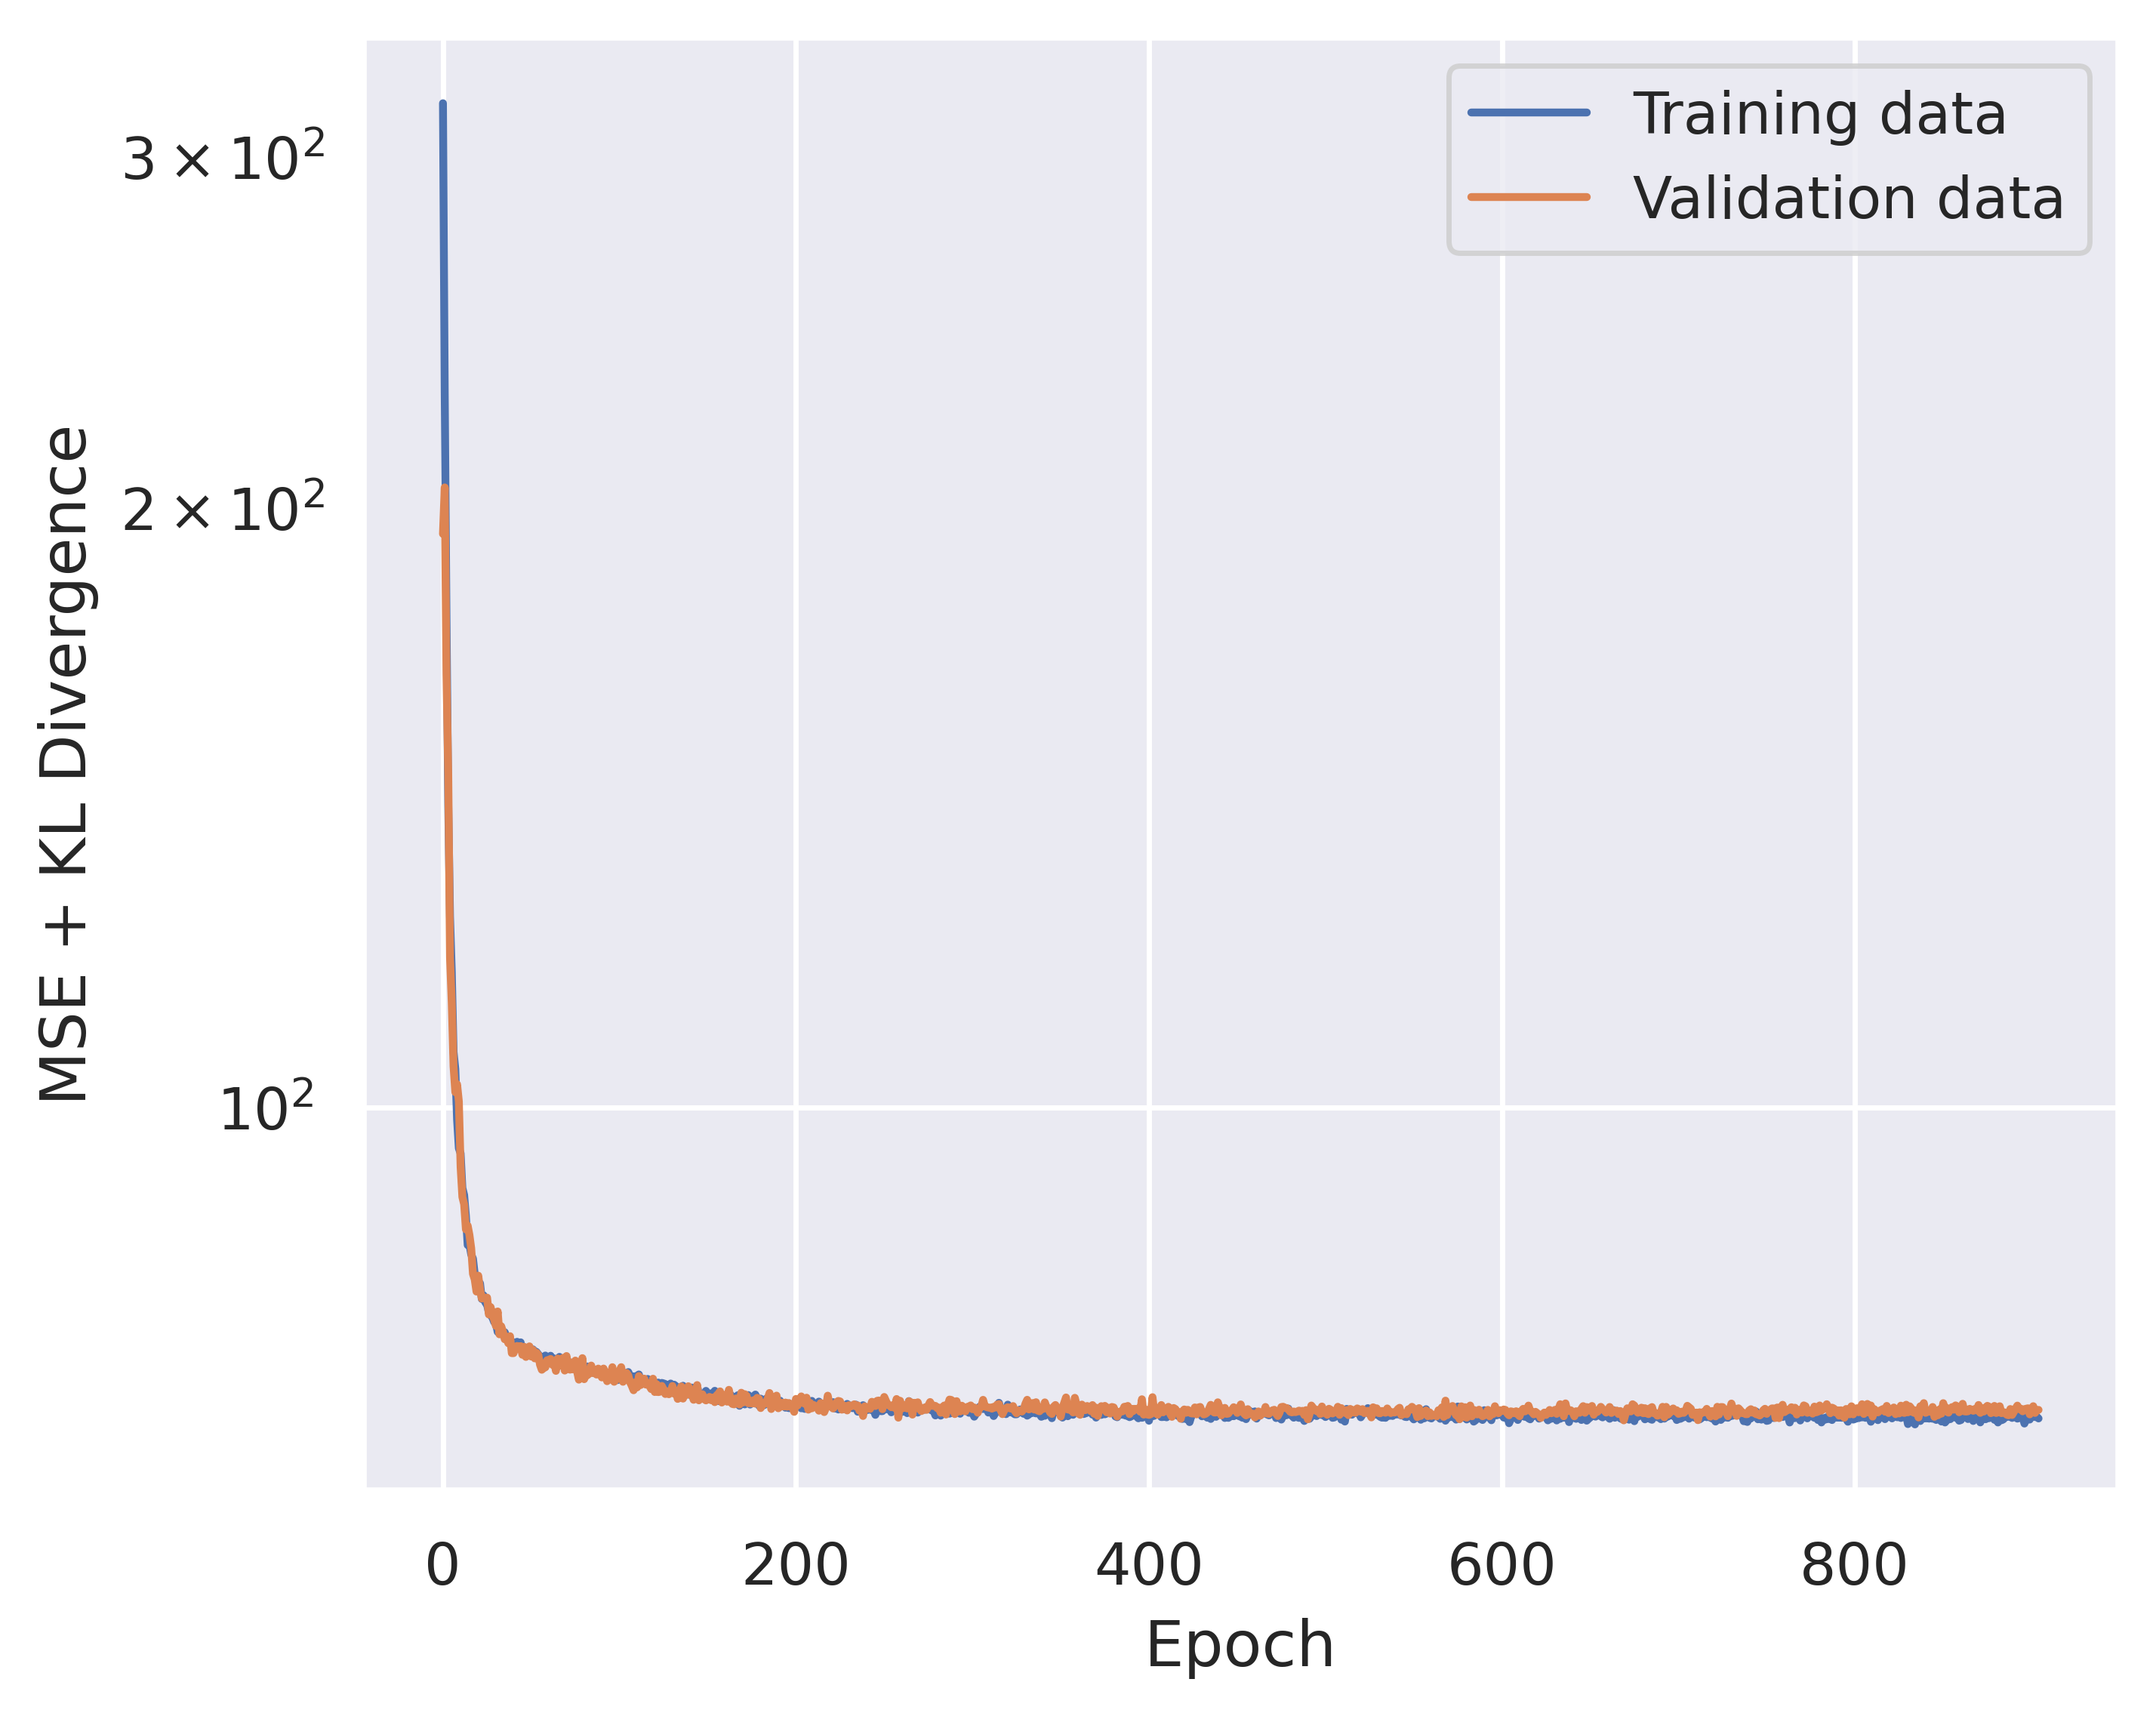

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-002016,Adult,Female,train
1,ACH-002459,Adult,Male,train
2,ACH-002084,Adult,Female,train
3,ACH-000911,Adult,Male,train
4,ACH-002243,Adult,Female,train
...,...,...,...,...
907,ACH-001619,Adult,Male,test
908,ACH-001270,Pediatric,Male,test
909,ACH-000878,Adult,Male,test
910,ACH-000563,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 0s 6ms/step


,ModelID,0,1,2,3,4,5,6,7,8,9
0,ACH-002016,-0.663319,-0.666636,-1.101474,-0.735374,4.060013,-0.137438,-0.450869,0.781322,-0.610973,1.350209
1,ACH-002459,-0.003515,-0.026361,0.707413,-0.698437,0.215731,0.943055,-1.751468,-0.832169,-0.360138,-0.768451
2,ACH-002084,0.705740,0.805310,-0.952868,0.347236,0.602867,-0.749033,-0.784060,0.499736,0.630579,1.847696
3,ACH-000911,0.617828,1.454695,1.492215,0.563274,0.492753,-0.538054,-0.264390,-1.144280,-1.018357,0.107914
4,ACH-002243,-0.266781,-1.228505,0.357569,-1.551512,-0.725471,0.137597,0.803791,-0.331259,0.156762,-1.593064


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.000776,-0.182148,-0.145655,0.163493,0.046534,-0.070291,0.066918,0.114472,-0.208144,0.096360
1,-0.165700,-0.014118,0.164734,-0.240282,0.022240,-0.109944,-0.101748,-0.018010,-0.000716,-0.031678
2,0.004751,0.209441,0.018309,-0.112892,0.272021,-0.032097,-0.158448,-0.255144,-0.307853,-0.145137
3,-0.108087,0.431431,-0.036791,0.042621,0.087107,0.113526,-0.148631,-0.126367,0.008173,0.376883
4,0.033362,0.249796,-0.038313,-0.293302,0.007984,-0.156843,0.044967,-0.189906,-0.025856,0.144821


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,10
0,FAM50A,-0.000776,-0.182148,-0.145655,0.163493,0.046534,-0.070291,0.066918,0.114472,-0.208144,0.096360
1,CDK6,-0.165700,-0.014118,0.164734,-0.240282,0.022240,-0.109944,-0.101748,-0.018010,-0.000716,-0.031678
2,CDAN1,0.004751,0.209441,0.018309,-0.112892,0.272021,-0.032097,-0.158448,-0.255144,-0.307853,-0.145137
3,GPX4,-0.108087,0.431431,-0.036791,0.042621,0.087107,0.113526,-0.148631,-0.126367,0.008173,0.376883
4,SEPHS2,0.033362,0.249796,-0.038313,-0.293302,0.007984,-0.156843,0.044967,-0.189906,-0.025856,0.144821
